In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns

from torchvision import transforms
from torchviz import make_dot
from torchvision import models

from library import RetinopathyDataset, SLORandomPad, FundRandomRotate, ResNET18C, ResNet18WithSAM, GradCAM, visualize_gradcam, run_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
torch.manual_seed(0)
batch_size = 24
num_classes = 5  # 5 DR levels
learning_rate = 0.0001
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((210, 210)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(90),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.RandomInvert(p=0.7), # 0.7
    transforms.RandomGrayscale(p=0.5), # 0.5
    transforms.RandomPerspective(p=0.3), # 0.3    
    transforms.GaussianBlur(kernel_size=5), # 5
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
mode = 'single'

models = {
    #"ResNET-DUAL": models.resnet18(weights=models.ResNet18_Weights.DEFAULT),
    "ResNET": models.resnet18(weights=models.ResNet18_Weights.DEFAULT),
    "ResNET50": models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
    "ResNET18C": ResNET18C(num_classes=num_classes),
    "VGG": models.vgg16(weights=models.VGG16_Weights.DEFAULT),
    "DenseNET": models.densenet161(weights=models.DenseNet161_Weights.DEFAULT),
    "ResNETWithSAM": ResNet18WithSAM(num_classes=num_classes)
}

kappas = {}
metrics = {}
preds = {}
labels = {}

for name, model in models.items():
    print(f'\nTraining model {name}')
    if "DUAL" in name:
        mode = 'dual'
    else:
        mode = 'single'
    models[name], kappas[name], metrics[name], preds[name], labels[name] = run_model(mode, name, model, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, transform_train=transform_train, transform_test=transform_test)


Training model ResNET
Device: cuda

Epoch 1/1
Training: 100%|██████████| 100/100 [00:38<00:00,  2.60 batch/s, lr=1.0e-04, Loss=1.1662]
[Train] Kappa: 0.0026 Accuracy: 0.3975 Precision: 0.4317 Recall: 0.3975 Loss: 2.9863
[Train] Class 0: Precision: 0.6147, Recall: 0.7181
[Train] Class 1: Precision: 0.4159, Recall: 0.2729
[Train] Class 2: Precision: 0.2991, Recall: 0.2188
[Train] Class 3: Precision: 0.3824, Recall: 0.3521
[Train] Class 4: Precision: 0.2783, Recall: 0.1333
[Train] Class 5: Precision: 0.0000, Recall: 0.0000
[Train] Class 6: Precision: 0.0000, Recall: 0.0000
[Train] Class 7: Precision: 0.0000, Recall: 0.0000
[Train] Class 8: Precision: 0.0000, Recall: 0.0000
[Train] Class 9: Precision: 0.0000, Recall: 0.0000
[Train] Class 10: Precision: 0.0000, Recall: 0.0000
[Train] Class 11: Precision: 0.0000, Recall: 0.0000
[Train] Class 12: Precision: 0.0000, Recall: 0.0000
[Train] Class 13: Precision: 0.0000, Recall: 0.0000
[Train] Class 14: Precision: 0.0000, Recall: 0.0000
[Train] C

g:\My Drive\Koulu\deep-learning\project\DeepLearning9\521153S-3005-final-project\library.py:468: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./{}_

Evaluating: 100%|██████████| 34/34 [00:11<00:00,  3.08 batch/s]
[Test] Save predictions to g:\My Drive\Koulu\deep-learning\project\DeepLearning9\521153S-3005-final-project\test_predictions_model_1_ResNET.csv


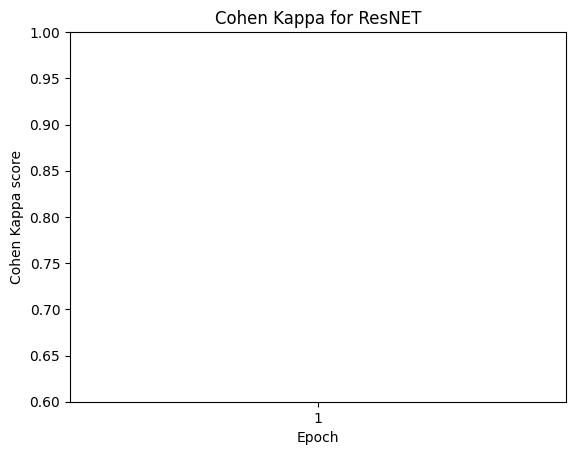

In [5]:
x = np.arange(1, num_epochs + 1, dtype=int)
x = list(map(str, x))
plt.plot(x, kappas['ResNET'])
plt.ylim(0.6, 1.0)
plt.xlabel("Epoch")
plt.ylabel("Cohen Kappa score")
plt.title("Cohen Kappa for {}".format(name))
plt.show()

{'ResNET': (0.7786507045766304, 0.615, 0.6451047584142691, 0.615)}


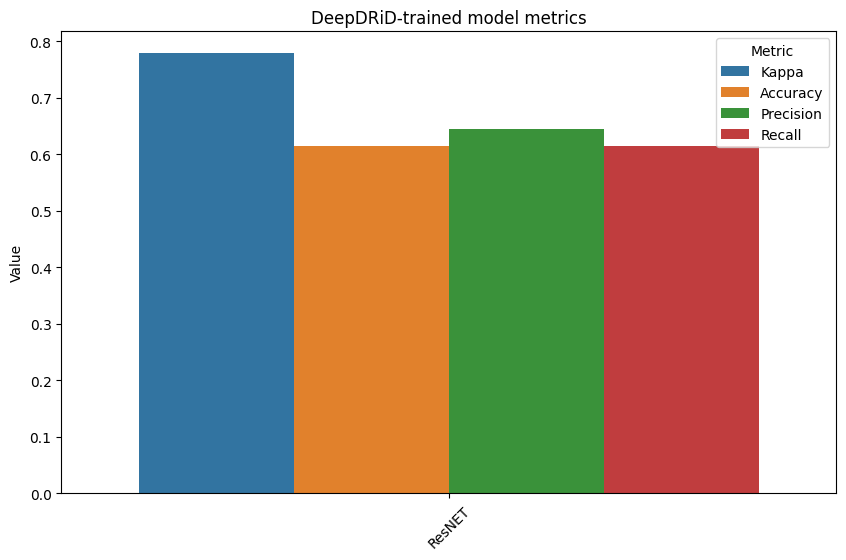

In [6]:
print(metrics)

metrics_df = pd.DataFrame(metrics)
metrics_df.index = ['Kappa', 'Accuracy', 'Precision', 'Recall']
metrics_df = metrics_df.T
metrics_df = metrics_df.reset_index()
metrics_df = pd.melt(metrics_df, id_vars='index', var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
plt.title('DeepDRiD-trained model metrics')
plt.xticks(rotation=45)
ax = sns.barplot(x='index', y='Value', hue='Metric', data=metrics_df)
ax.set_xlabel('')
plt.show()

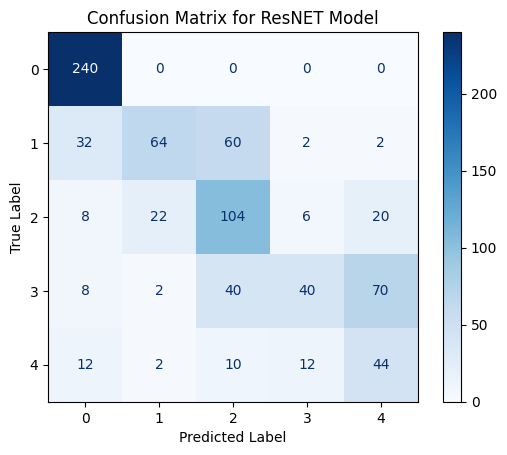

In [7]:
true_labels = labels['ResNET']
predictions = preds['ResNET']

cm = confusion_matrix(true_labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(true_labels))
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix for ResNET Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

C:\Users\Ari Timonen\AppData\Local\Temp\ipykernel_10548\182990791.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./model_1_ResNET.pth', map_loc

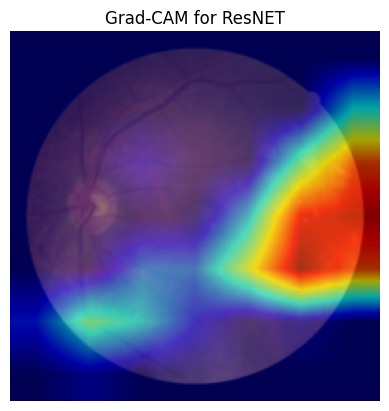

In [8]:
model_cam = models["ResNET"]
state_dict = torch.load('./model_1_ResNET.pth', map_location='cpu')
model_cam.load_state_dict(state_dict)

model_cam.to(device)
model_cam.eval()

test_dataset = RetinopathyDataset('./DeepDRiD/test.csv',
                                   './DeepDRiD/test/',
                                   transform_test,
                                   mode='single',
                                   test=True)

input_tensor = test_dataset[random.randint(0, len(test_dataset) - 1)].unsqueeze(0)
input_tensor = input_tensor.to(device)

target_layer = model_cam.layer4[-1].conv2
grad_cam = GradCAM(model_cam, target_layer)

cam = grad_cam.generate_cam(input_tensor, target_class=None)

visualize_gradcam(input_tensor[0], cam, title="Grad-CAM for ResNET")

grad_cam.remove_hooks()


In [9]:
sample_sizes = [0.1]
kappas_sample = {}
metrics_sample = {}
model_sample = models["ResNET"]

for sample_size in sample_sizes:
    print(f'\nTraining model with sample size {sample_size}')
    model_sample, kappas_sample[sample_size], metrics_sample[sample_size], _, _ = run_model(
        mode, f"ResNET_sample_{sample_size}",
        model_sample,
        num_epochs=10,
        batch_size=batch_size,
        learning_rate=learning_rate,
        sampled=sample_size
    )


Training model with sample size 0.1
Device: cuda

Epoch 1/10
Training: 100%|██████████| 10/10 [00:03<00:00,  3.16 batch/s, lr=1.0e-04, Loss=0.3759]
[Train] Kappa: 0.9075 Accuracy: 0.8292 Precision: 0.8370 Recall: 0.8292 Loss: 0.6198
[Train] Class 0: Precision: 0.9140, Recall: 0.9444
[Train] Class 1: Precision: 0.8750, Recall: 0.7000
[Train] Class 2: Precision: 0.6800, Recall: 0.7727
[Train] Class 3: Precision: 0.7059, Recall: 0.8000
[Train] Class 4: Precision: 0.9032, Recall: 0.7778
Evaluating: 100%|██████████| 34/34 [00:11<00:00,  2.95 batch/s]
[Val] Kappa: 0.7316 Accuracy: 0.6075 Precision: 0.5795 Recall: 0.6075

Epoch 2/10
Training: 100%|██████████| 10/10 [00:03<00:00,  3.25 batch/s, lr=1.0e-04, Loss=0.0341]
[Train] Kappa: 0.9952 Accuracy: 0.9792 Precision: 0.9799 Recall: 0.9792 Loss: 0.1007
[Train] Class 0: Precision: 0.9890, Recall: 1.0000
[Train] Class 1: Precision: 0.9512, Recall: 0.9750
[Train] Class 2: Precision: 1.0000, Recall: 0.9545
[Train] Class 3: Precision: 1.0000, Reca

g:\My Drive\Koulu\deep-learning\project\DeepLearning9\521153S-3005-final-project\library.py:468: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./{}_


[Val] Kappa: 0.7459 Accuracy: 0.5850 Precision: 0.5667 Recall: 0.5850
[Val] Best kappa: 0.7702, Epoch 2
Evaluating: 100%|██████████| 34/34 [00:10<00:00,  3.25 batch/s]
[Test] Save predictions to g:\My Drive\Koulu\deep-learning\project\DeepLearning9\521153S-3005-final-project\test_predictions_model_1_ResNET_sample_0.1.csv


C:\Users\Ari Timonen\AppData\Local\Temp\ipykernel_10548\178490320.py:5: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log(sample_sizes), best_kappa_scores, 1)
C:\Users\Ari Timonen\AppData\Local\Temp\ipykernel_10548\178490320.py:8: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log(sample_sizes), best_accuracy_scores, 1)


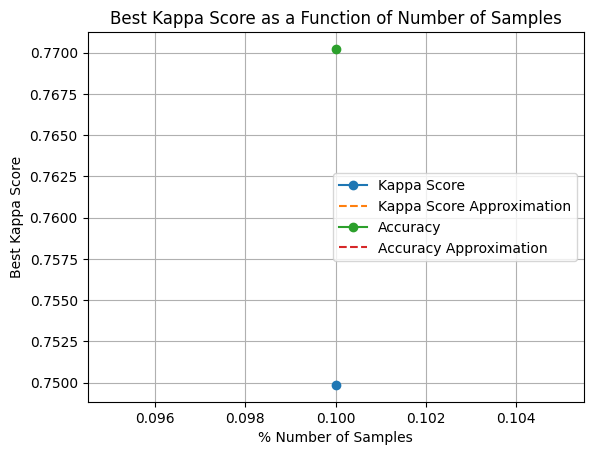

In [10]:
sample_sizes = list(kappas_sample.keys())
best_kappa_scores = [np.mean(kappas_sample[size]) for size in sample_sizes]
best_accuracy_scores = [metrics_sample[size][0] for size in sample_sizes]

coeffs = np.polyfit(np.log(sample_sizes), best_kappa_scores, 1)
approximated_kappas = np.polyval(coeffs, np.log(sample_sizes))

coeffs = np.polyfit(np.log(sample_sizes), best_accuracy_scores, 1)
approximated_accuracies = np.polyval(coeffs, np.log(sample_sizes))

plt.figure()
plt.plot(sample_sizes, best_kappa_scores, marker='o')
plt.plot(sample_sizes, approximated_kappas, linestyle='--')
plt.plot(sample_sizes, best_accuracy_scores, marker='o')
plt.plot(sample_sizes, approximated_accuracies, linestyle='--')
plt.xlabel('% Number of Samples')
plt.ylabel('Best Kappa Score')
plt.title('Best Kappa Score as a Function of Number of Samples')
plt.grid(True)
plt.legend(['Kappa Score', 'Kappa Score Approximation', 'Accuracy', 'Accuracy Approximation'])
plt.show()



C:\Users\Ari Timonen\AppData\Local\Temp\ipykernel_10548\2573429000.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./model_1_ResNET.pth', map_lo

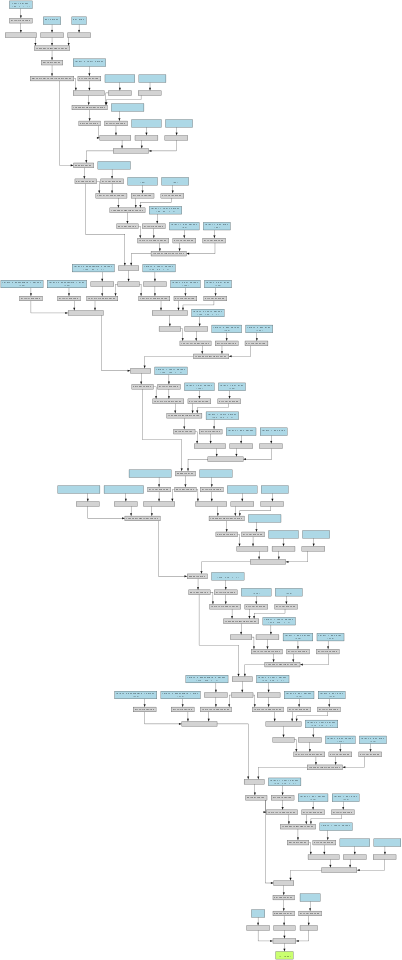

In [12]:
model_vis = models["ResNET"]

state_dict = torch.load('./model_1_ResNET.pth', map_location='cpu')
model_vis.load_state_dict(state_dict)

model_vis.to(device)
model_vis.eval()

test_dataset = RetinopathyDataset('./DeepDRiD/test.csv',
                                   './DeepDRiD/test/',
                                   transform_test,
                                   mode='single',
                                   test=True)

input_tensor = test_dataset[random.randint(0, len(test_dataset) - 1)].unsqueeze(0)
input_tensor = input_tensor.to(device)

dot = make_dot(model_vis(input_tensor), params=dict(model_vis.named_parameters()))
dot.graph_attr.update({
    'size': "10,10",
    'rankdir': "TB",
    'splines': "ortho"
})
dot.node_attr.update({
    'shape': 'box',
    'fontsize': '10',
})
dot.render("resnet_graph", format="png")
from IPython.display import Image
display(Image(filename="resnet_graph.png"))

In [ ]:
#state_dict = torch.load('./model_1_ResNET-0.8645.pth', map_location='cpu')
#modelR.load_state_dict(state_dict, strict=True)

# Make predictions on testing set and save the prediction results
#evaluate_model(modelR, test_loader, device, test_only=True, prediction_path="./model_1_ResNET-0.8645.csv")

In [ ]:
import os
import sys

import kagglehub
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from library import train_model

In [ ]:
num_epochs = 4

In [ ]:
# Run only in Google Colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive/')

# Download latest version
path = kagglehub.dataset_download("mariaherrerot/aptos2019")

print("Path to dataset files:", path)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class APTOSDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform

        self.test = test

        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.get_item(index)

    # 1. single image
    def load_data(self):
        df = pd.read_csv(self.ann_file)

        data = []
        for _, row in df.iterrows():
            file_info = dict()
            file_info['img_path'] = os.path.join(self.image_dir, row['id_code'] + ".png")
            file_info['diagnosis'] = row['diagnosis']
            data.append(file_info)
        return data

    def get_item(self, index):
        data = self.data[index]
        img = Image.open(data['img_path']).convert('RGB')
        if self.transform:
            img = self.transform(img)

        if not self.test:
            label = torch.tensor(data['diagnosis'], dtype=torch.int64)
            return img, label
        else:
            return img
        
def train_and_save(model_tuple):
  name, model = model_tuple
  train_dataset = APTOSDataset(path + '/train_1.csv', path + '/train_images/train_images/', preprocess)
  val_dataset = APTOSDataset(path + '/valid.csv', path + '/val_images/val_images/', preprocess)
  test_dataset = APTOSDataset(path + '/test.csv', path + '/test_images/test_images/', preprocess, test=True)

  # Create dataloaders
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  #test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  # Define the weighted CrossEntropyLoss
  criterion = nn.CrossEntropyLoss()

  # Use GPU device is possible
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Device:', device)

  # Move class weights to the device
  model = model.to(device)

  # Optimizer and Learning rate scheduler
  optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

  # Train and evaluate the model with the training and validation set
  model, kappas, val_metrics, _, _ = train_model(
      model, train_loader, val_loader, device, criterion, optimizer,
      lr_scheduler=lr_scheduler, num_epochs=num_epochs,
      checkpoint_path='./model_aptos-2019-pretrained_{}.pth'.format(name)
  )
  return model, kappas, val_metrics

modelsA = {
    "ResNET": models.resnet18(weights=models.ResNet18_Weights.DEFAULT),
    "VGG": models.vgg16(weights=models.VGG16_Weights.DEFAULT),
    "DenseNET": models.densenet161(weights=models.DenseNet161_Weights.DEFAULT)
}

metrics = {}
kappas = {}

for name, model in modelsA.items():
    print(f'\nTraining model {name}')
    modelsA[name], kappas[name], metrics[name] = train_and_save((name, model))

In [ ]:
torch.manual_seed(0)
batch_size = 24
num_classes = 5  # 5 DR levels
learning_rate = 0.0001
num_epochs = 5

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((210, 210)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(90),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.RandomInvert(p=0.7), # 0.7
    transforms.RandomGrayscale(p=0.5), # 0.5
    transforms.RandomPerspective(p=0.3), # 0.3    
    transforms.GaussianBlur(kernel_size=5), # 5
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

models2 = {
    "ResNET": models.resnet18(),
    "VGG": models.vgg16(),
    "DenseNET": models.densenet161()
}

state_dicts = {
    'ResNET': './model_aptos-2019-pretrained_ResNET.pth',
    'VGG': './model_aptos-2019-pretrained_VGG.pth',
    'DenseNET': './model_aptos-2019-pretrained_DenseNet.pth',
}

kappas = {}
metrics = {}

for name, model in models2.items():
    print(f'\nTraining model {name}')

    state_dict = torch.load(state_dicts[name], map_location='cpu')
    model.load_state_dict(state_dict, strict=True)

    for param in model.parameters():
        param.requires_grad = True
    
    models2[name], kappas[name], metrics[name], _, _ = run_model("single", name, model, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, transform_train=transform_train, transform_test=transform_test)

print(metrics)

metrics_df = pd.DataFrame(metrics)
metrics_df.index = ['Kappa', 'Accuracy', 'Precision', 'Recall']
metrics_df = metrics_df.T
metrics_df = metrics_df.reset_index()
metrics_df = pd.melt(metrics_df, id_vars='index', var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
plt.title('APTOS and DeepDRiD fine-tuned models')
plt.xticks(rotation=45)
ax = sns.barplot(x='index', y='Value', hue='Metric', data=metrics_df)
ax.set_xlabel('')
plt.show()